In [2]:
import librosa
import numpy as np
import random
import rosbag
import struct
import tams_pr2_guzheng
from collections import Counter
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn-v0_8')
from matplotlib.animation import FuncAnimation
from IPython import display

%load_ext autoreload
%autoreload 1
import sys
if '../utils' not in sys.path:
    sys.path.append('../utils')
import u
%aimport u

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
bag_name = "guzheng_150_fis4_random_ypos_2023-06-15-18-57-36_extracted_episodes.bag"

In [8]:
bag_name = "guzheng_150_fis4_random_ypos_dir-1.0_2023-06-15-19-18-40_extracted_episodes.bag"

In [4]:
note = "fis4"

In [9]:
bag = rosbag.Bag("../../../../bags/" + bag_name)
episodes_full_bag = [m for t, m, _ in bag.read_messages()]

# limit analysis to a single string
episodes_all = [e for e in episodes_full_bag if e.string == note]

# drop invalid samples
episodes_valid = [
    e
    for e in episodes_all
    if (
        len(e.detected_audio_onsets) == 0
        or len(e.detected_audio_onsets) > 0
        and e.start_execution < e.detected_audio_onsets[0].header.stamp
        and e.string in [u.note_to_string(o.note) for o in e.detected_audio_onsets]
    )
    and len(e.executed_path.poses) > 0
]
episodes = episodes_valid
episodes_with_onset = [e for e in episodes if len(e.detected_audio_onsets) > 0]
episodes_with_one_onset = [e for e in episodes if len(e.detected_audio_onsets) == 1]
episodes_with_no_onset = [e for e in episodes if len(e.detected_audio_onsets) == 0]

In [10]:
def normalize(X):
    return (X - np.mean(X)) / np.std(X), (np.mean(X), np.std(X))

value_repeat= 1

string_position = np.tile(np.array([e.action_parameters.action_parameters[-1] for e in episodes_with_one_onset]), value_repeat)
string_position_norm, string_position_norm_params = normalize(string_position)
keypoint_pos_y = np.tile(np.array([e.action_parameters.action_parameters[10] for e in episodes_with_onset]), value_repeat)
keypoint_pos_y_norm, keypoint_pos_y_norm_params = normalize(keypoint_pos_y)

features = np.stack((string_position_norm, keypoint_pos_y_norm)).T
loudness = np.tile(np.array([e.detected_audio_onsets[0].loudness for e in episodes_with_onset]), value_repeat)
loudness_norm, loudness_norm_params = normalize(loudness)

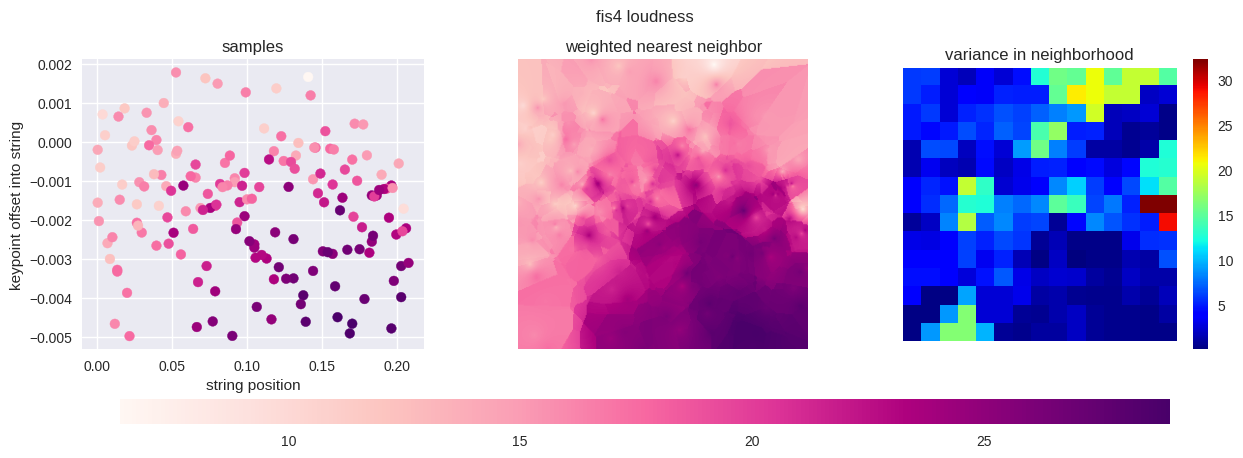

In [13]:
def normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))


x = string_position
y = keypoint_pos_y
c = loudness

from scipy.spatial import cKDTree

grid_size = 300
# output grid
weighted_nearest_neighbor = np.zeros((grid_size, grid_size))
# coordinates
xi, yi = np.meshgrid(np.linspace(0, 1, grid_size), np.linspace(0, 1, grid_size))
grid_points = np.column_stack((xi.ravel(), yi.ravel()))
tree = cKDTree(np.column_stack((normalize(x), normalize(y))))
distances, indices = tree.query(grid_points, k=3)
for i in range(grid_size):
    for j in range(grid_size):
        weights = 1.0 / distances[i * grid_size + j]  # Inverse of distances as weights
        weights /= np.sum(weights)  # Normalize weights
        weighted_nearest_neighbor[i, j] = np.dot(c[indices[i * grid_size + j]], weights)

grid_size = 15
# output grid
vari = np.zeros((grid_size, grid_size))
# coordinates
xi, yi = np.meshgrid(np.linspace(0, 1, grid_size), np.linspace(0, 1, grid_size))
grid_points = np.column_stack((xi.ravel(), yi.ravel()))
tree = cKDTree(np.column_stack((normalize(x), normalize(y))))
distances, indices = tree.query(grid_points, k=5)
for i in range(grid_size):
    for j in range(grid_size):
        neighborhood = c[indices[i * grid_size + j]]
        vari[i, j] = np.var(neighborhood)

cmap = plt.get_cmap("RdPu")
# cmap=plt.get_cmap('brg')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"{note} loudness")
# Q.plot(x='string_position', y='keypoint_pos_y', kind='scatter', c='loudness', colormap='brg', ax=ax[0], colorbar=False)
ax[0].scatter(x, y, c=c, cmap=cmap)
ax[0].set_title("samples")
ax[0].set_xlabel("string position")
ax[0].set_ylabel("keypoint offset into string")

im = ax[1].imshow(weighted_nearest_neighbor, cmap=cmap, origin="lower")
ax[1].axis("off")
ax[1].set_title("weighted nearest neighbor")

imvar = ax[2].imshow(vari, cmap="jet", origin="lower")
ax[2].axis("off")
ax[2].set_title("variance in neighborhood")
fig.colorbar(imvar, ax=ax[2])

fig.subplots_adjust(bottom=0.3)
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.05])
fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
u.save_plot(f"string kp_ypos {note} {bag_name}")


In [14]:
def predict_grid():
    grid_size = 100
    # coordinates
    xi, yi = np.meshgrid(
        np.linspace(np.min(features[:,0]), np.max(features[:,0]), grid_size),
        np.linspace(np.min(features[:,1]), np.max(features[:,1]), grid_size)
        )
    grid_points = np.column_stack((xi.ravel(), yi.ravel()))
    means, std = GPR.predict(grid_points, return_std=True)
    means = means.reshape((grid_size, grid_size))
    std = std.reshape((grid_size, grid_size))
    return means, std

In [15]:
import sklearn.gaussian_process as gp

In [16]:
lmin = np.min(loudness)
lmax = np.max(loudness)

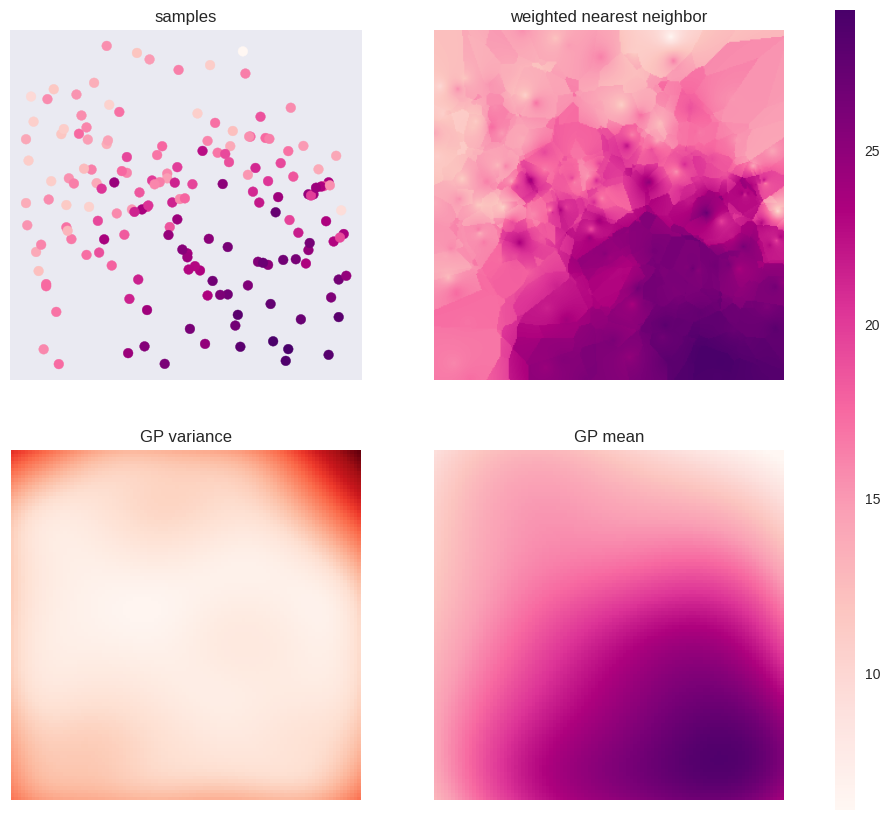

In [25]:
GPR= gp.GaussianProcessRegressor(n_restarts_optimizer=100, alpha=0.5**2)

N= -1
GPR.fit(features[:N], loudness[:N]);

fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("samples")
plt.scatter(features[:N,0], features[:N,1], c=loudness[:N], cmap=cmap)

# plt.colorbar()
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,2)
plt.title("weighted nearest neighbor")
plt.imshow(weighted_nearest_neighbor, origin='lower', cmap=cmap, vmin=lmin, vmax=lmax)
# plt.colorbar()
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,3)
plt.title("GP variance")
plt.imshow(predict_grid()[1], origin='lower', cmap='Reds')
# plt.colorbar()
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.subplot(2,2,4)
plt.title("GP mean")
plt.imshow(predict_grid()[0], origin='lower', cmap=cmap, vmin=lmin, vmax=lmax)
plt.grid(False)
plt.xticks([])
plt.yticks([])
# set equal aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
# plt.subplots_adjust(left= 0.0, right=0.01)
plt.colorbar(cax=plt.axes([0.95, 0.1, 0.02, 0.8]));

#plt.tight_layout()
plt.savefig("GP fit.png", dpi=300)

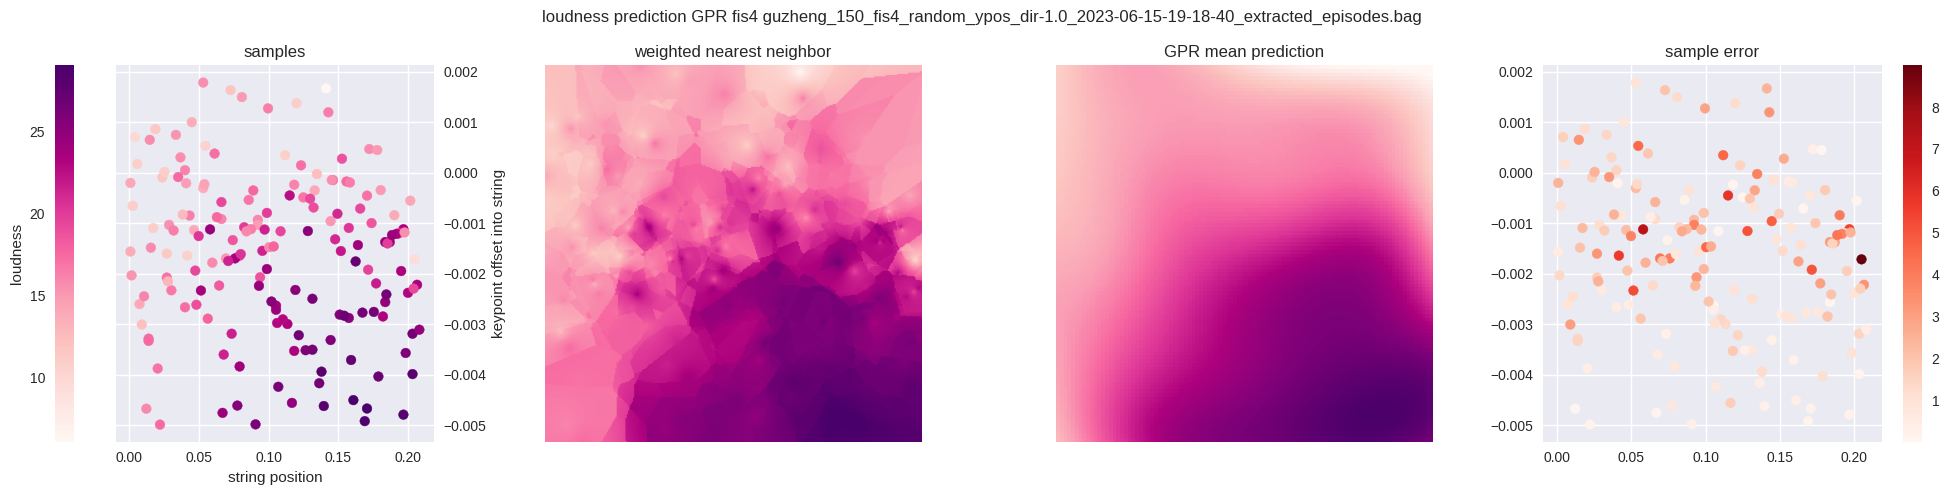

In [282]:
def plot_prediction_overview():
    predicted_loudness = GPR.predict(features)

    fig = plt.figure(figsize=(20, 5), dpi=100)
    sample_ax = plt.subplot(1, 4, 1)
    plt.suptitle(f"loudness prediction GPR {note} {bag_name}")
    sample_plt = plt.scatter(x, y, c=loudness, cmap=cmap)
    plt.gca().set_title("samples")
    plt.gca().set_xlabel("string position")
    plt.gca().set_ylabel("keypoint offset into string")
    plt.gca().yaxis.set_label_position("right")
    plt.gca().yaxis.tick_right()
    cbar = plt.colorbar(sample_plt, location='left')
    # add label to colorbar
    cbar.ax.set_ylabel('loudness')

    plt.subplot(1, 4, 2)
    plt.imshow(weighted_nearest_neighbor, cmap=cmap, origin="lower", vmin=lmin, vmax=lmax)
    plt.axis("off")
    plt.title("weighted nearest neighbor")

    means, std = predict_grid()
    plt.subplot(1, 4, 3)
    plt.imshow(means, origin='lower', cmap=cmap, vmin=lmin, vmax=lmax)
    plt.axis('off');
    plt.title(f"GPR mean prediction")

    plt.subplot(1,4,4)

    error= np.abs(loudness - predicted_loudness)
    plt.title('sample error')
    plt.scatter(x,y, c=error, cmap='Reds')
    plt.colorbar()

    plt.tight_layout()
    return fig

fig = plot_prediction_overview();
u.save_plot(fig._suptitle.get_text());